<a href="https://colab.research.google.com/github/bipin-a/Machine-Learning-Notes/blob/main/Neural_Network_30_Forecast.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import math
import numpy as np
from scipy.stats import entropy
from scipy.signal import find_peaks
from sklearn.preprocessing import PowerTransformer
from datetime import timedelta
from math import log2
from scipy.signal import peak_prominences
import tensorflow as tf
import json
import random
import gc
from typing import Union
from collections import namedtuple
import pickle
import numpy.typing as npt
import keras

In [3]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available:  0


In [4]:
from google.colab import drive
drive.mount('/content/drive')
data_dir = "/content/drive/Shareddrives/BipinA/Neural_Networks_Data/"

Mounted at /content/drive


In [5]:
class MinMax:
  def scale(self,X:pd.Series, min:int, max: int):
    return  (X - min) / (max - min) 

class Standardize:
  def scale(self, X:pd.Series, mean:int, std: int) -> pd.Series:
    return (X-mean) / std

class Nada:
  def scale(self, X:pd.Series, mean:int, std: int) -> pd.Series:
    return None

In [6]:
gc.enable()
gc.collect()
INPUT_SIZE = 300
output_sizes = [30,120,270]
STEP_SIZE = 3
minmaxscaler = MinMax()
standardizescaler = Standardize()
nada = Nada()
n_features = 1

In [7]:
Experiment = namedtuple("Experiment", "X_train Y_train X_test Y_test X_val Y_val OUTPUT_SIZE scaler_name TS_Train TS_Test TS_Val")
Experiment_30 = {}
OUTPUT_SIZE = 30
for scaler in [minmaxscaler, standardizescaler, nada]:
  scaler_name = type(scaler).__name__
  EXP_NAME = str(OUTPUT_SIZE) + str(scaler_name)
  
  with open(f"{data_dir}_ExperimentDictionary_{EXP_NAME}.pickle", 'rb') as f:
        Experiment_30[EXP_NAME] = pickle.load(f)

In [8]:
Experiment_30.keys()

dict_keys(['30MinMax', '30Standardize', '30Nada'])

# Models

In [9]:
def create_CNN(INPUT_SIZE, OUTPUT_SIZE):

  CONV_WIDTH = 3
  multi_conv_model = tf.keras.Sequential([
      # Shape [batch, time, features] => [batch, CONV_WIDTH, features]
      tf.keras.layers.Lambda(lambda x: x[:, -CONV_WIDTH:, :]),
      # Shape => [batch, 1, conv_units]
      tf.keras.layers.Conv1D(256, activation='relu', kernel_size=(CONV_WIDTH)),
      # Shape => [batch, 1,  out_steps*features]
      tf.keras.layers.Dense(OUTPUT_SIZE*1,
                            kernel_initializer=tf.initializers.zeros()),
      # Shape => [batch, out_steps, features]
      tf.keras.layers.Reshape([OUTPUT_SIZE, 1])
  ])

  return multi_conv_model

In [10]:
def create_FFNN(INPUT_SIZE, OUTPUT_SIZE):

  dense = tf.keras.Sequential([
  tf.keras.layers.Dense(INPUT_SIZE, activation="relu", input_shape=(INPUT_SIZE,)), 
  tf.keras.layers.Dense(units=128, activation='relu'),
  tf.keras.layers.Dense(units=128, activation='relu'),
  tf.keras.layers.Dense(units=128, activation='relu'),
  tf.keras.layers.Dense(units=64, activation='relu'),
  tf.keras.layers.Dense(units=64, activation='relu'),
  tf.keras.layers.Dense(units=OUTPUT_SIZE)])

  return dense

In [11]:
# def create_RNN(INPUT_SIZE, OUTPUT_SIZE):
#   rnn = tf.keras.Sequential([
#     # Shape [batch, time, features] => [batch, lstm_units].
#     # Adding more `lstm_units` just overfits more quickly.
#     tf.keras.layers.SimpleRNN(32, return_sequences=False),
#     # Shape => [batch, out_steps*features].
#     tf.keras.layers.Dense(OUTPUT_SIZE*1,
#                           kernel_initializer=tf.initializers.zeros()),
#     # Shape => [batch, out_steps, features].
#     tf.keras.layers.Reshape([OUTPUT_SIZE, 1])
#     ])
#   return rnn


In [12]:
def create_LSTM(INPUT_SIZE, OUTPUT_SIZE):
  lstm = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, lstm_units].
    # Adding more `lstm_units` just overfits more quickly.
    tf.keras.layers.LSTM(32, return_sequences=False),
    # Shape => [batch, out_steps*features].
    tf.keras.layers.Dense(OUTPUT_SIZE*1,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features].
    tf.keras.layers.Reshape([OUTPUT_SIZE, 1])
    ])
  return lstm


# Evaluate

In [13]:
def compile_and_fit(model,X_train, Y_train,X_val,y_val,
                    metric, loss, max_epoch,patience=4):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min') # Minimizing the metric

  model.compile(loss= loss,
                optimizer=tf.optimizers.Adam(),
                metrics=[metric])

  history = model.fit(X_train, Y_train, epochs=max_epoch,
                      validation_data=(X_val,y_val),
                      callbacks=[early_stopping])
  return history

def cumaltive_error(y_true, y_pred):
    squared_difference = tf.square(y_true - y_pred)
    return tf.reduce_mean(squared_difference, axis=-1)  # Note the `axis=-1`

In [14]:
loss=tf.losses.MeanAbsolutePercentageError()
metric=tf.metrics.MeanAbsolutePercentageError()

# See which models work best on which proccessed data

In [15]:
gc.collect()

53

In [16]:
for k,E in Experiment_30.items():
  print(k)

30MinMax
30Standardize
30Nada


In [18]:
MAX_EPOCHS = 20
Experiment_results = {}
for k,E in Experiment_30.items():
  Experiment_results[k] = {}
  print("Running experiment: ",k)
  lstm_model = create_LSTM(INPUT_SIZE, E.OUTPUT_SIZE)
  # rnn_model = create_RNN(INPUT_SIZE, E.OUTPUT_SIZE)
  cnn_model = create_CNN(INPUT_SIZE, E.OUTPUT_SIZE)
  ffnn_model = create_FFNN(INPUT_SIZE, E.OUTPUT_SIZE)

  for model, model_name in [(cnn_model,"cnn"), (ffnn_model,"ffnn"), (lstm_model, "lstm")]:
    print("Using model", model_name)
    try:
      model = tf.keras.models.load_model(f"{data_dir}_{k}_{model_name}")
    except:
      history = compile_and_fit(model,
                                E.X_train, E.Y_train, E.X_val, E.Y_val, 
                                metric, loss, max_epoch = MAX_EPOCHS)
      model.save(f"{data_dir}_{k}_{model_name}", save_format='tf')

    y_pred = model.predict(E.X_test)
    gc.collect()
  
    try:
      Experiment_results[k][model_name] = {"history":history, "y_pred": y_pred}
    except:
      # History of loaded model isn't saved
      Experiment_results[k][model_name] = {"y_pred": y_pred}

gc.collect()

Running experiment:  30MinMax
Using model cnn
Using model ffnn
Using model lstm
Running experiment:  30Standardize
Using model cnn
Using model ffnn
Using model lstm
Running experiment:  30Nada
Using model cnn
Using model ffnn
Using model lstm


0

0
1
2
0
1
2
0
1
2


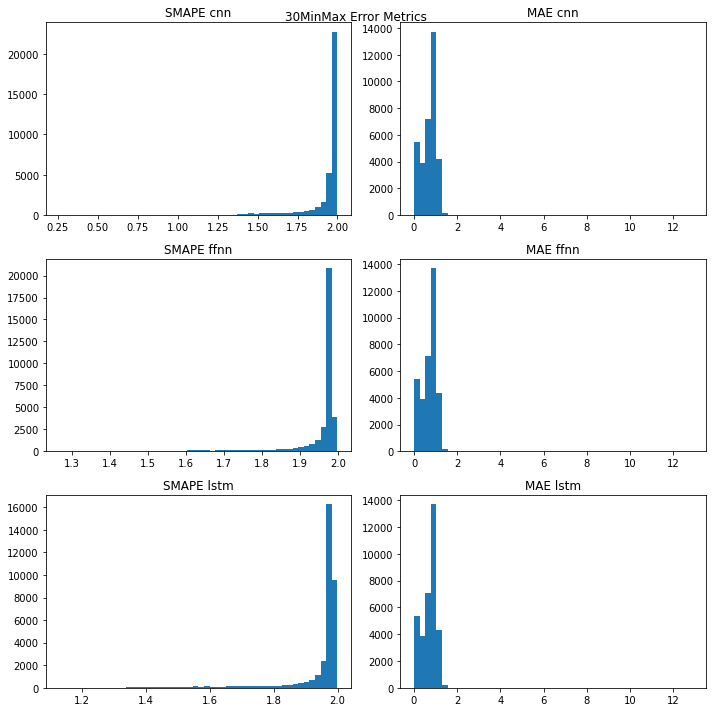

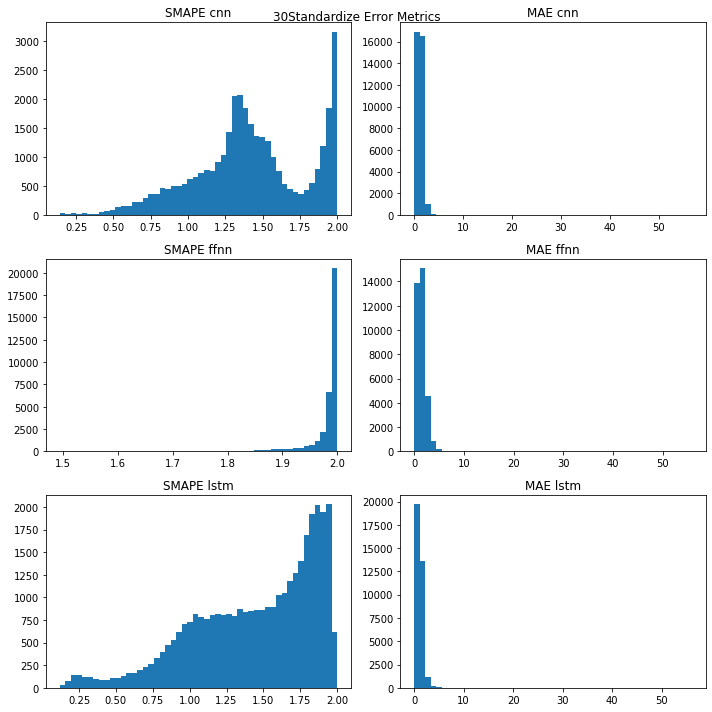

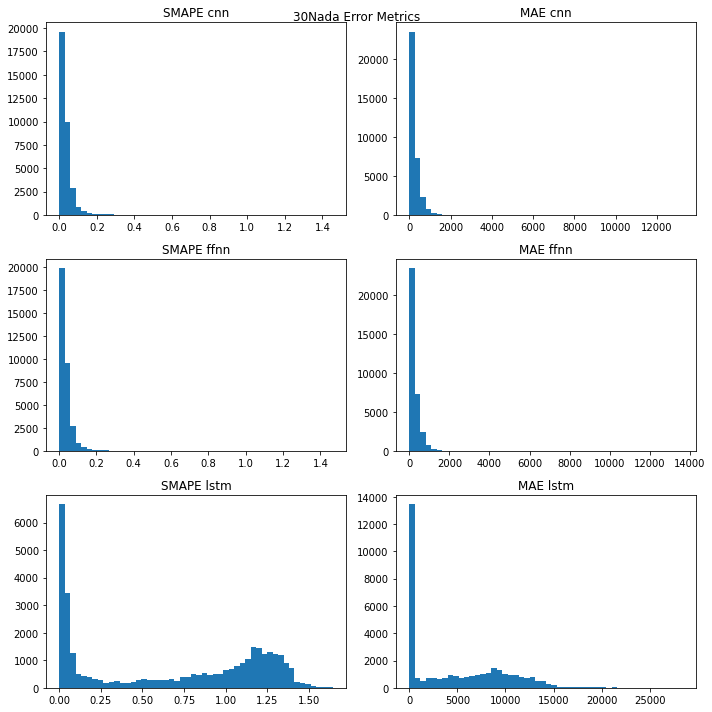

In [48]:
experiment_dfs = {}

for k,v in Experiment_results.items():
    P = Experiment_results[k]
    E = Experiment_30[k]
    truth = E.Y_test
    df = pd.DataFrame()

    fig,axes = plt.subplots(3,2,figsize=(10,10))
    fig.suptitle(f"{k} Error Metrics")

    for i, (model_name, predictions) in enumerate(P.items()):
      
      print(i)
      pred = predictions.get("y_pred")
      if model_name in ["cnn",'lstm']:
        pred = np.squeeze(pred)

      _num = abs(pred - truth)
      _denom = (abs(pred) + abs(truth)) / 2
      smape_error = np.mean(_num/_denom, axis=1)
      _ = axes[i][0].hist(smape_error, bins=50)
      axes[i][0].set_title(f"SMAPE {model_name}")

      mae_error = np.mean(abs((truth-pred)),axis=1)
      _ = axes[i][1].hist(mae_error, bins=50)
      axes[i][1].set_title(f"MAE {model_name}")

      df[model_name] = pd.Series(smape_error).rename(f"{model_name}")

      plt.tight_layout()
      fig.savefig(f"{data_dir}/imgs/{k}ErrorMetrics.png")
    df['TS_ID'] = E.TS_Test
    experiment_dfs[k] = df.to_dict()
    


In [55]:
summary = pd.DataFrame(experiment_dfs['30MinMax'])


In [57]:
summary

,cnn,ffnn,lstm,TS_ID
0,1.958121,1.972732,1.969785,D637
1,1.964601,1.971212,1.970156,D637
2,1.963789,1.970929,1.971881,D637
3,1.959725,1.969683,1.970254,D637
4,1.956096,1.965946,1.969763,D637
...,...,...,...,...
34645,1.973308,1.980250,1.979858,W294
34646,1.972693,1.979465,1.980506,W294
34647,1.973239,1.980000,1.979816,W294
34648,1.972855,1.980827,1.980392,W294


In [66]:
daily_features = pd.concat([pd.read_csv(f"{data_dir}daily_features.csv"),pd.read_csv(f"{data_dir}daily_features_pt2.csv")])
weekly_features = pd.read_csv(f"{data_dir}weekly_features.csv")
monthly_features = pd.concat([pd.read_csv(f"{data_dir}monthly_features_1.csv"),
                              pd.read_csv(f"{data_dir}monthly_features_2.csv"),
                              pd.read_csv(f"{data_dir}monthly_features_3.csv"),
                              pd.read_csv(f"{data_dir}monthly_features_4.csv"),
                              pd.read_csv(f"{data_dir}monthly_features_5.csv"),
                              ])
all_features = pd.concat([daily_features,weekly_features,monthly_features])
del daily_features, weekly_features, monthly_features
all_features['FREQ']=all_features['V1'].apply(lambda x :x[0])


In [67]:
cols = ['f_linearity','f_entropy','f_all_seasonality_strength','f_trend_strength','V1','FREQ']
all_features = all_features[cols]

In [68]:
all_features

,f_linearity,f_entropy,f_all_seasonality_strength,f_trend_strength,V1,FREQ
0,0.973209,9.958312,0.895773,0.998701,D1,D
1,0.587550,9.986778,0.697496,0.980055,D2,D
2,0.164803,7.167537,0.198473,0.325886,D3,D
3,0.034539,7.496995,0.093767,0.112556,D4,D
4,0.858135,7.371108,0.064006,0.909748,D5,D
...,...,...,...,...,...,...
1995,0.641946,6.261576,0.792982,0.951414,M9996,M
1996,0.696387,6.357279,0.605250,0.873595,M9997,M
1997,0.828145,6.259761,0.156435,0.871005,M9998,M
1998,0.791964,6.315970,0.198224,0.898742,M9999,M


In [69]:
gc.collect()

197

In [71]:
! pip install plotly

In [72]:
import plotly.express as px

In [73]:
features_summary = pd.merge(summary,all_features, how='inner', left_on ='TS_ID', right_on='V1')

In [74]:
features_summary

,cnn,ffnn,lstm,TS_ID,f_linearity,f_entropy,f_all_seasonality_strength,f_trend_strength,V1,FREQ
0,1.958121,1.972732,1.969785,D637,0.650487,10.222214,0.621709,0.943462,D637,D
1,1.964601,1.971212,1.970156,D637,0.650487,10.222214,0.621709,0.943462,D637,D
2,1.963789,1.970929,1.971881,D637,0.650487,10.222214,0.621709,0.943462,D637,D
3,1.959725,1.969683,1.970254,D637,0.650487,10.222214,0.621709,0.943462,D637,D
4,1.956096,1.965946,1.969763,D637,0.650487,10.222214,0.621709,0.943462,D637,D
...,...,...,...,...,...,...,...,...,...,...
34645,1.973308,1.980250,1.979858,W294,0.170635,10.152335,0.807658,0.743973,W294,W
34646,1.972693,1.979465,1.980506,W294,0.170635,10.152335,0.807658,0.743973,W294,W
34647,1.973239,1.980000,1.979816,W294,0.170635,10.152335,0.807658,0.743973,W294,W
34648,1.972855,1.980827,1.980392,W294,0.170635,10.152335,0.807658,0.743973,W294,W
